### Human TF analysis
###### last updated 2024-10-28
This notebook analyzes all human TFs and generates panels for ...

This notebook requires [metapredict](https://metapredict.readthedocs.io/en/latest/) and [shephard](https://shephard.readthedocs.io/en/latest/). Both packages were developed by the Holehouse lab and can be installed using `pip` via

    pip install metapredict, shephard


In [52]:
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
	
# Set such that PDF fonts export in a manner that they
# are editable in illustrator/affinity
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# set to define axes linewidths
matplotlib.rcParams['axes.linewidth'] = 0.5

# this defines some prefactors so inline figures look nice
# on a retina macbook. These can be commented out without any
# issue and are solely asthetic.
%matplotlib inline
%config InlineBackend.figure_format='retina'

# UPDATE 2020-12-31 (my preferred font is Avenir...)
font = {'family' : 'arial',
    	'weight' : 'normal'}

matplotlib.rc('font', **font)


In [55]:
from shephard import interfaces 
from shephard.apis import uniprot
from shephard.apis import metapredict_api
import metapredict as meta

### Annotate with IDRs across all TFs and across human proteome
NOTE this requires the most recent version of SHEPHARD that will only be released once metapredict V3 is pushed to master and on PyPI.

In [77]:
RECOMPUTE = False
SAVE_DATA = False


# Read in the set of human transcription factors as a SHEPHARD Proteome object
TFs = uniprot.uniprot_fasta_to_proteome('human_TFs_full.fasta')

# note we have the invalid_sequence_action='convert' as there are a couple of 'X' residues in
# human proteome we convert.
HP  = uniprot.uniprot_fasta_to_proteome('UP000005640_9606.fasta', invalid_sequence_action='convert')


# if recompute we recalculate all IDRs
if RECOMPUTE:
    # ~4 seconds
    metapredict_api.annotate_proteome_with_disordered_domains(TFs)

    # ~60 seconds
    metapredict_api.annotate_proteome_with_disordered_domains(HP)

    # if save data save these annotations
    if SAVE_DATA:
        interfaces.si_domains.write_domains(TFs, 'data/TF_IDRs_v3.tsv')
        interfaces.si_domains.write_domains(HP, 'data/HP_IDRs_v3.tsv')

        # save human TF UIDs
        fh = open('human_tf_uniprot_IDs.txt','w')
        for protein in TFs.proteins:
            fh.write(f"{protein}\n")
        fh.close()    



else:
    interfaces.si_domains.add_domains_from_file(TFs, 'data/TF_IDRs_v3.tsv')
    interfaces.si_domains.add_domains_from_file(HP, 'data/HP_IDRs_v3.tsv')

print('Finished loading...')
print(f"Human proteome loaded; {len(HP)} proteins and {len(HP.domains)} IDRs")
print(f"Human transcription factors loaded; {len(TFs)} proteins and {len(TFs.domains)} IDRs")    



Finished loading...
Human proteome loaded; 20656 proteins and 33713 IDRs
Human transcription factors loaded; 1608 proteins and 3488 IDRs


### Compute fraction of disorder 
The cell below cycles through each TF and computes t

In [78]:
fraction_disordered = []

number_disordered = []
number_ordered = []
prot_len = []

for protein in TFs:
    
    
    # generates a list with the length of each IDR in the protein
    IDR_lengths = [len(d) for d in protein.domains if d.domain_type == 'IDR' ]
    
    # calculates the fraction of the protein in the IDR
    fraction_disordered.append(np.sum(IDR_lengths)/len(protein))
    number_disordered.append(np.sum(IDR_lengths))
    number_ordered.append(len(protein)-np.sum(IDR_lengths))
    prot_len.append(len(protein))
    

sorted_lists = sorted(zip(prot_len, number_disordered, number_ordered),reverse=True)

# Unzip the sorted lists
sorted_list1, sorted_list2, sorted_list3 = zip(*sorted_lists)

# Convert back to lists if needed
prot_len = list(sorted_list1)
number_disordered = list(sorted_list2)
number_ordered = list(sorted_list3)

    

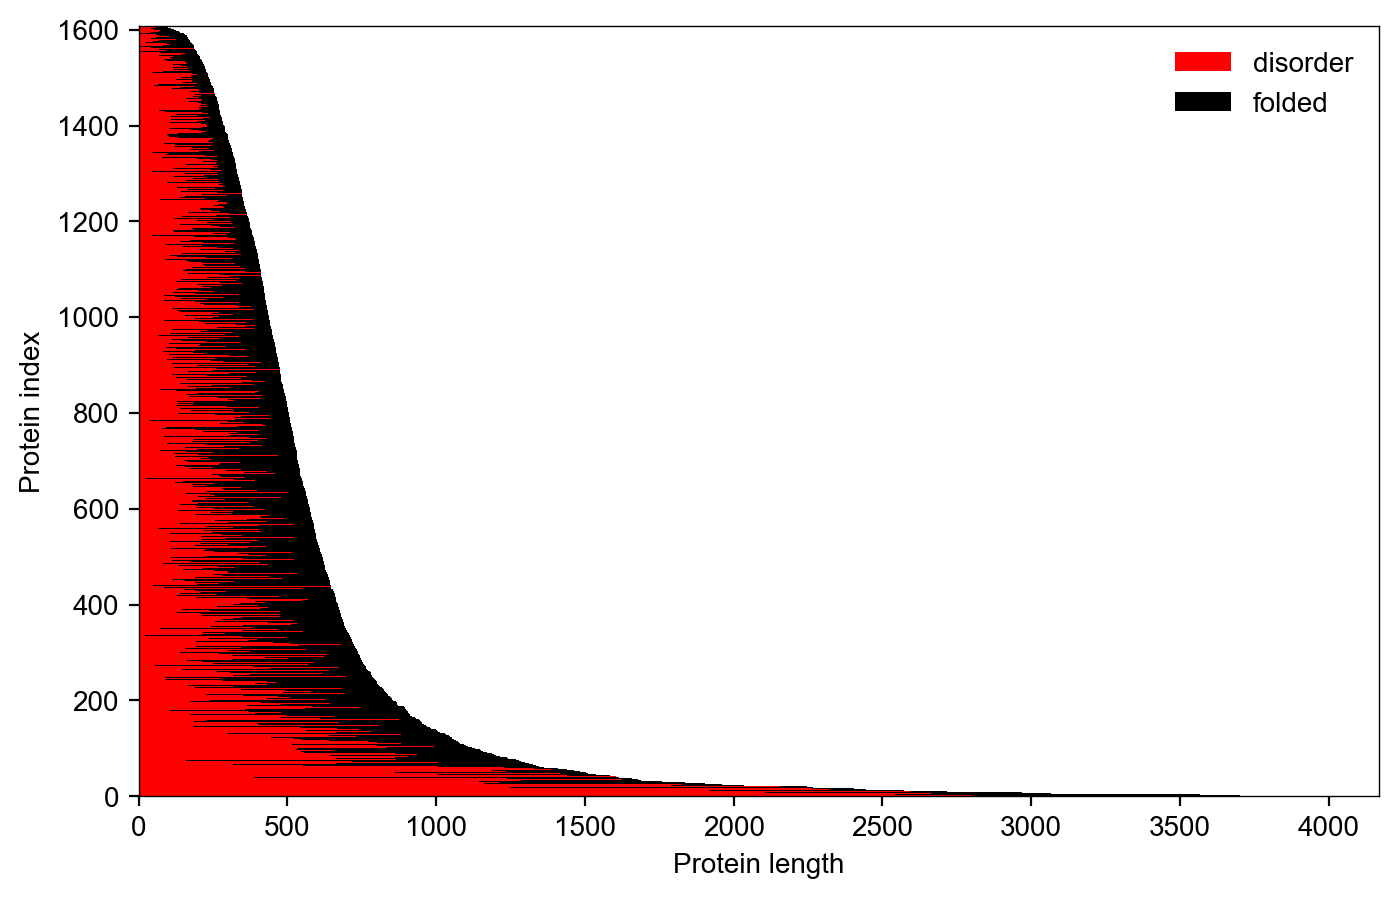

In [158]:
# Create the plot
fig, ax = plt.subplots(figsize=(8,5))
x = np.arange(len(sorted_list2))

ax.barh(x, number_disordered, label='disorder', color='r', height=1)
ax.barh(x, number_ordered, left=number_disordered, label='folded', color='k', height=1)  # Stacked on top

# Set labels and title
ax.set_xlabel('Protein length')
ax.set_ylabel('Protein index')
plt.ylim([x[0],x[-1]])


ax.legend(frameon=False)
plt.savefig('figures/human_TFs.pdf')



### Violin plot of disorder
The cell below generates and saves a violin plot of fractional disorder for human proteome vs. TFs

In [81]:
fraction_disordered_HP = []
for protein in HP:
    
    
    # generates a list with the length of each IDR in the protein
    IDR_lengths = [len(d) for d in protein.domains if d.domain_type == 'IDR' ]
    
    # calculates the fraction of the protein in the IDR
    fraction_disordered_HP.append(np.sum(IDR_lengths)/len(protein))


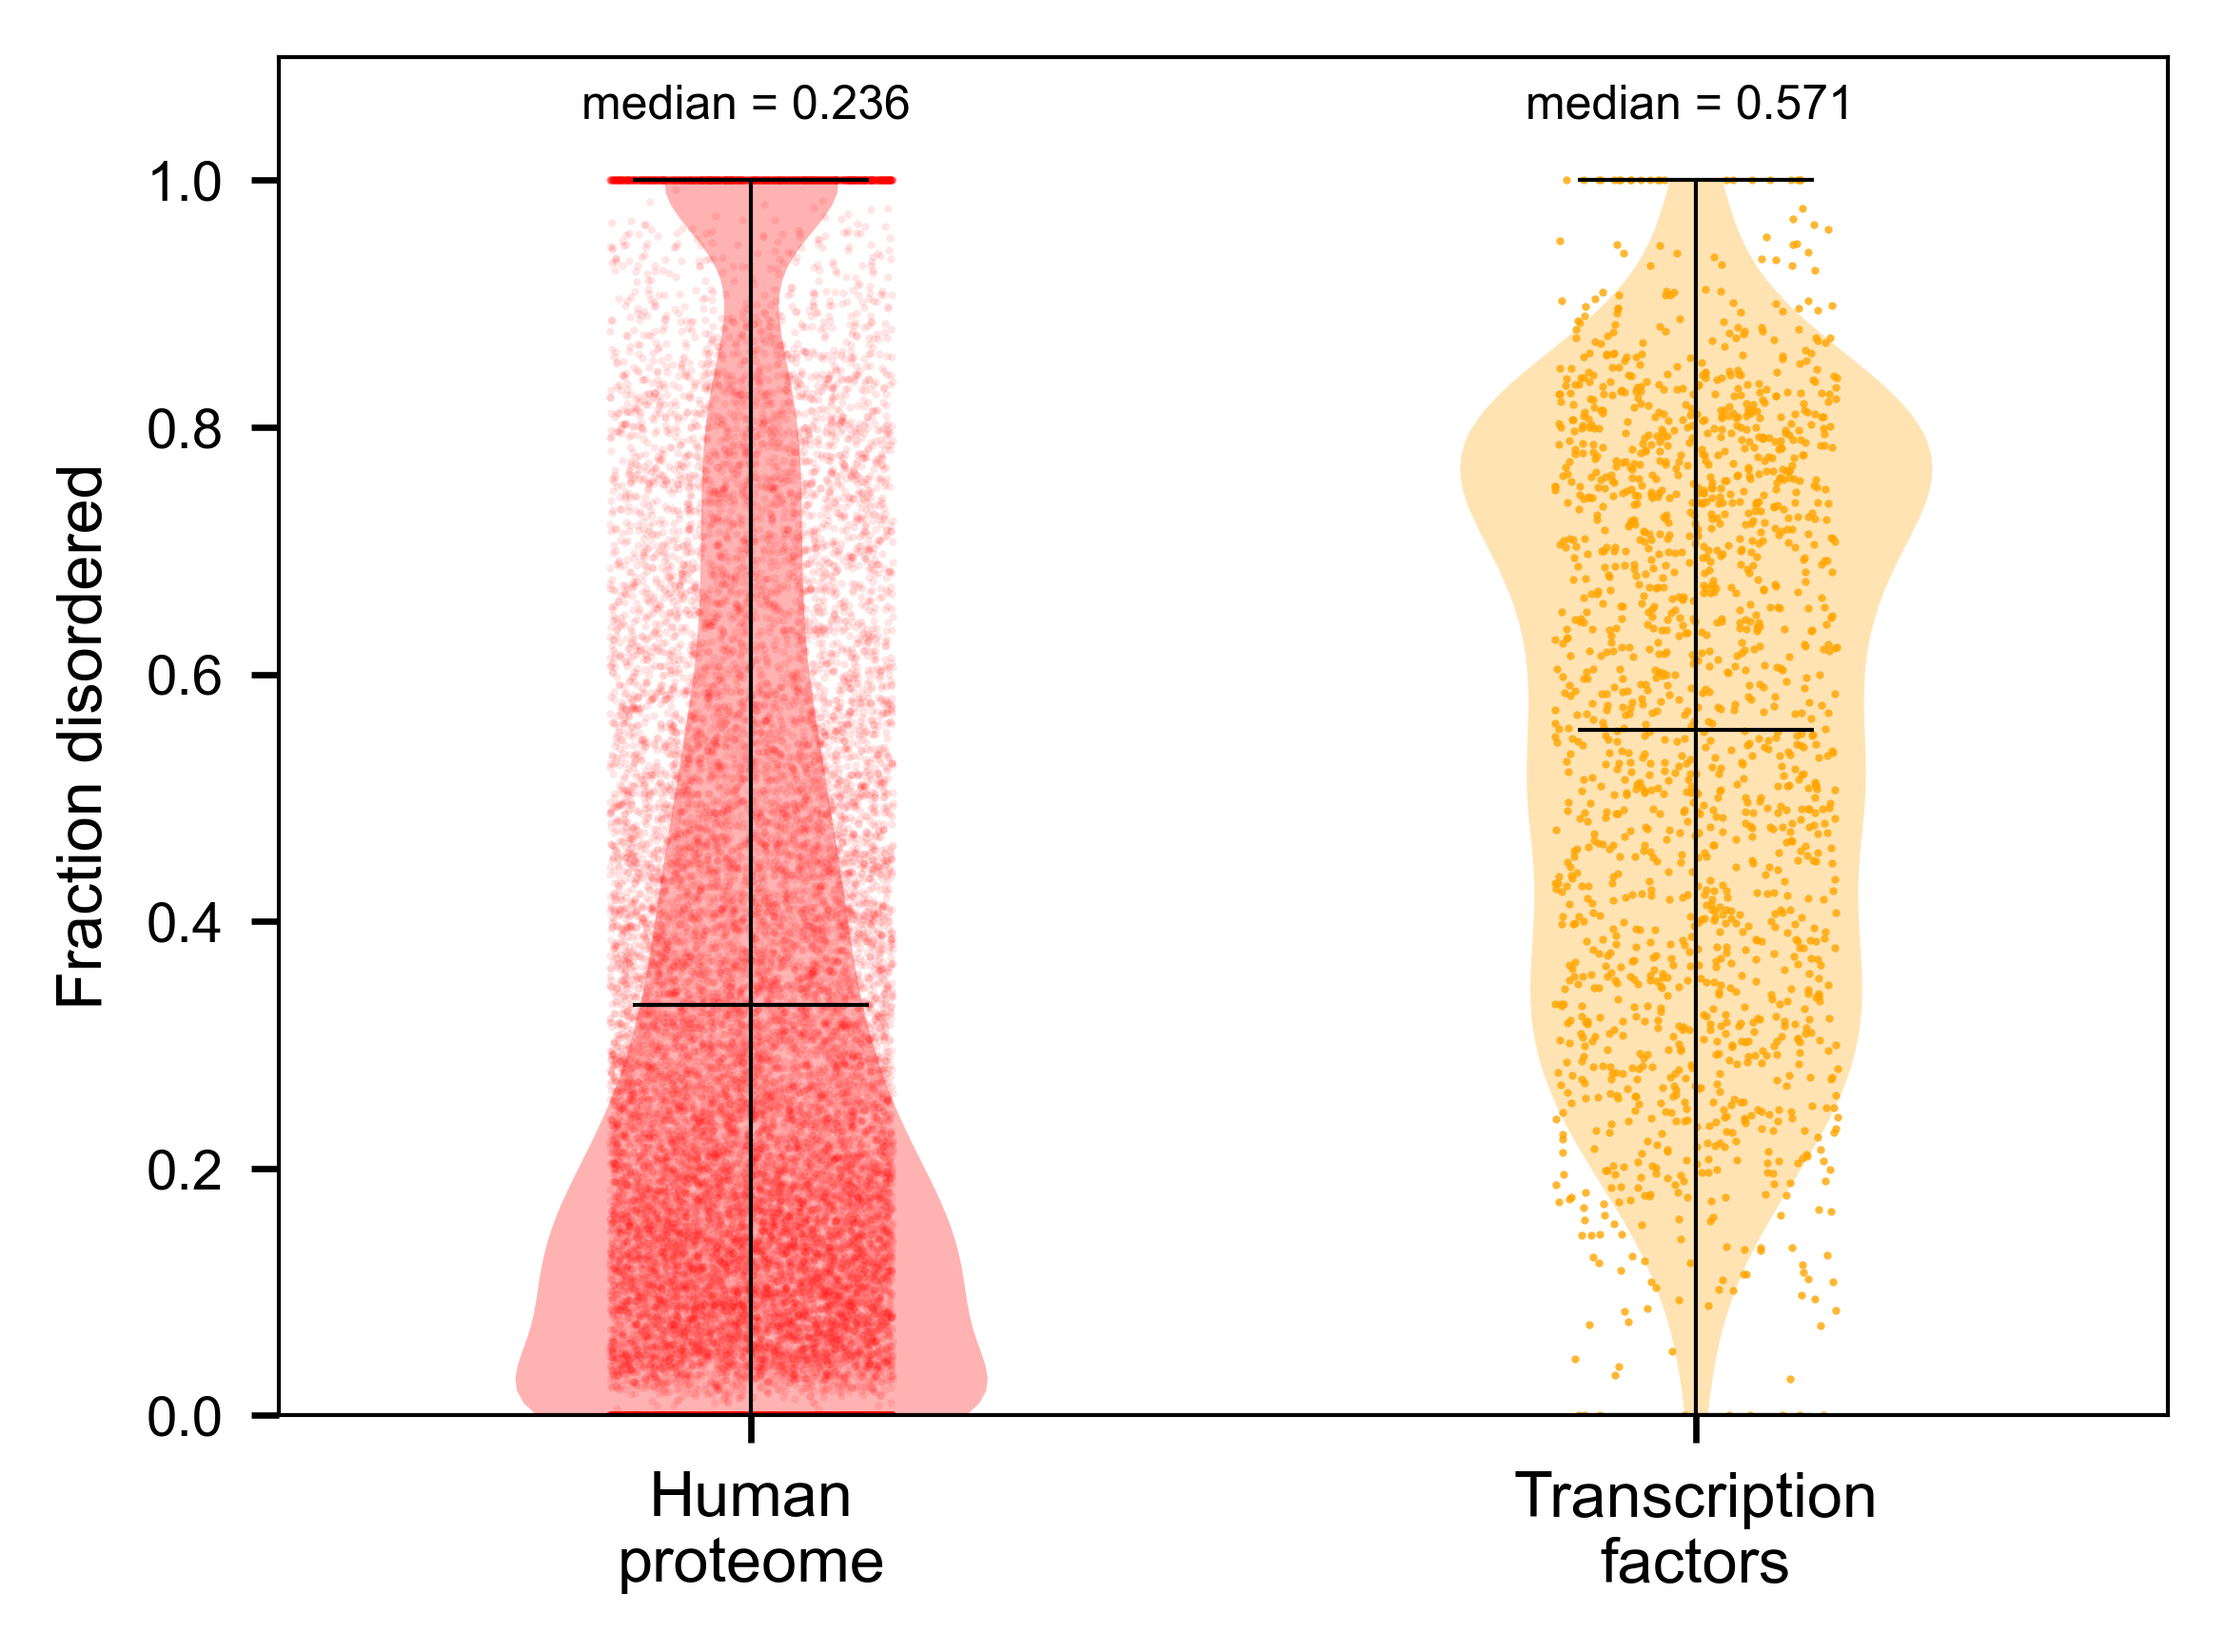

In [160]:
figure(num=None, figsize=(4, 3), dpi=300, facecolor='w', edgecolor='k')
ax = plt.gca()


count = len(fraction_disordered_HP)
plt.plot(np.array([1]*count)+(np.random.random(count)-0.5)*0.3, fraction_disordered_HP,'.',  color='red', alpha=0.1, ms=2, mew=0)

count = len(fraction_disordered)
plt.plot(np.array([2]*count)+(np.random.random(count)-0.5)*0.3, fraction_disordered, '.', color='orange', alpha=0.8, ms=2, mew=0)

plt.xlim([0,3])
parts = ax.violinplot([fraction_disordered_HP, fraction_disordered], showmeans=True)

bodies_new = parts['bodies'][0]
bodies_new.set_color('red')
bodies_new.set_linewidth(0)

bodies_new = parts['bodies'][1]
bodies_new.set_color('orange')
bodies_new.set_linewidth(0)


for partname in ('cbars','cmins','cmaxes','cmeans'):

    parts[partname].set_color('k')
    parts[partname].set_edgecolor('k')
    parts[partname].set_linewidth(0.5)

plt.xlim([0.5,2.5])    
plt.ylim([0,1.1])
plt.text(0.82,1.05,f'median = {round(np.median(fraction_disordered_HP),3)}',fontsize=6)
plt.text(1.82,1.05,f'median = {round(np.median(fraction_disordered),3)}',fontsize=6)

plt.xticks([1,2],['Human\nproteome','Transcription\nfactors'], fontsize=8)
plt.yticks(fontsize=7)
plt.ylabel('Fraction disordered', fontsize=8)

plt.tight_layout()
plt.savefig('figures/proteome_vs_tfs.pdf')


In [137]:
AAs = ['A','L','V','I','M','F','Y','W','P','S','G', 'Q','T','N','H','E','D','R','K','C']

proteome_idrs = {}
tf_idrs = {}

proteome = {} 
tfs = {}

for aa in AAs:
    proteome_idrs[aa] = 0
    tf_idrs[aa] = 0
    proteome[aa] = 0
    tfs[aa] = 0

for protein in HP:
    for d in protein.domains:
        for aa in d.sequence:
            proteome_idrs[aa] = proteome_idrs[aa] + 1

    for aa in protein.sequence:
        proteome[aa] = proteome[aa] + 1

# all TF stuff
for protein in TFs:
    for d in protein.domains:
        for aa in d.sequence:
            tf_idrs[aa] = tf_idrs[aa] + 1

    for aa in protein.sequence:
        tfs[aa] = tfs[aa] + 1


proteome_idrs = {aa:proteome_idrs[aa]/np.sum(list(proteome_idrs.values())) for aa in proteome_idrs}
proteome = {aa:proteome[aa]/np.sum(list(proteome.values())) for aa in proteome}

tf_idrs = {aa:tf_idrs[aa]/np.sum(list(tf_idrs.values())) for aa in tf_idrs}
tfs = {aa:tfs[aa]/np.sum(list(tfs.values())) for aa in tfs}


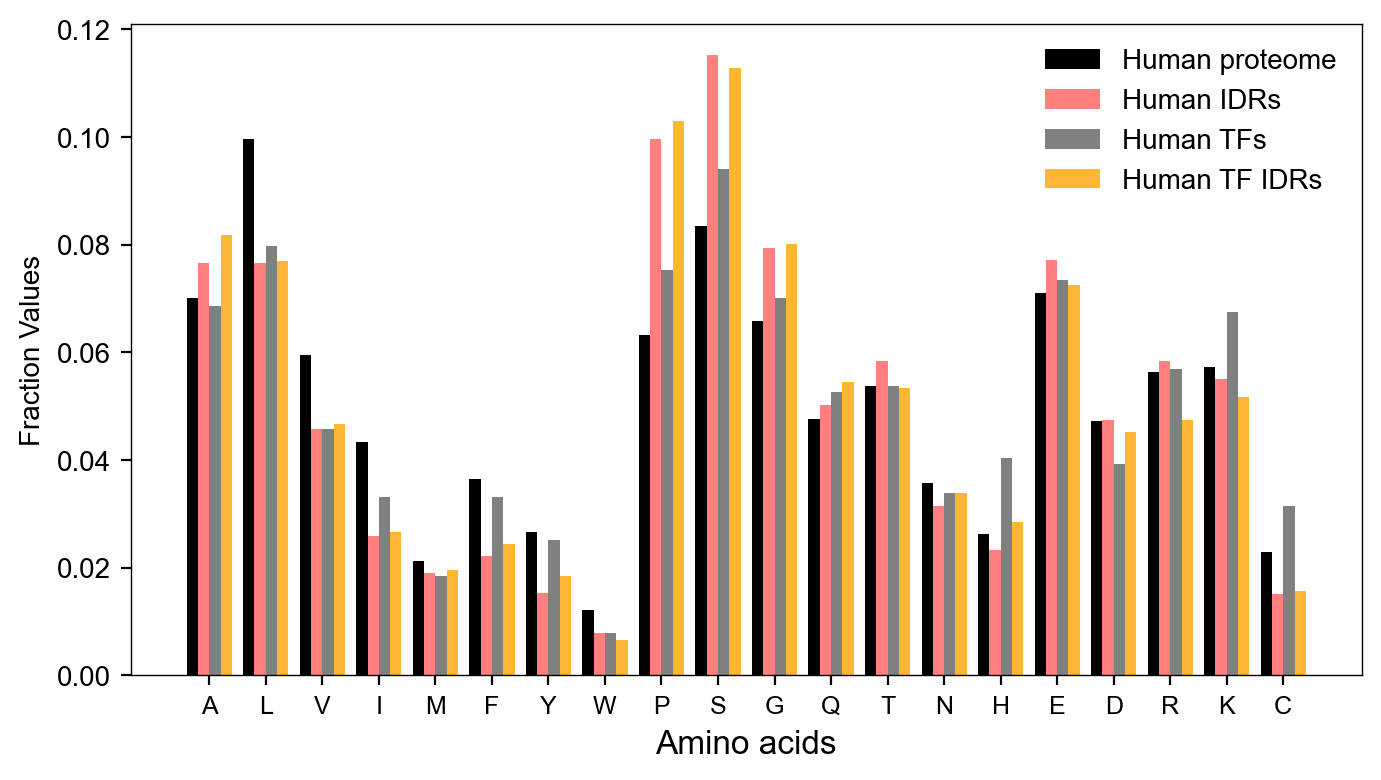

In [157]:
# Example data setup
keys = list(proteome.keys())  # Assuming all dictionaries have the same keys
proteome_values = [proteome[key] for key in keys]
proteome_idrs_values = [proteome_idrs[key] for key in keys]
tfs_values = [tfs[key] for key in keys]
tf_idrs_values = [tf_idrs[key] for key in keys]

# Parameters for plotting
num_keys = len(keys)
x = np.arange(num_keys)  # X-axis positions for each key
bar_width = 0.2  # Width of each bar within a group

# Create the plot
fig, ax = plt.subplots(figsize=(7, 4))

# Plot each dictionary's values as separate bars within each group
ax.bar(x - 1.5 * bar_width, proteome_values, width=bar_width, label="Human proteome", color='k')
ax.bar(x - 0.5 * bar_width, proteome_idrs_values, width=bar_width, label="Human IDRs", color='r', alpha=0.5)
ax.bar(x + 0.5 * bar_width, tfs_values, width=bar_width, label="Human TFs", color='grey')
ax.bar(x + 1.5 * bar_width, tf_idrs_values, width=bar_width, label="Human TF IDRs", color='orange', alpha=0.8)

# Labeling
ax.set_xlabel("Amino acids", fontsize=12)
ax.set_ylabel("Fraction Values")
ax.set_xticks(x)
ax.set_xticklabels(keys, rotation=0, ha="center", fontsize=9)
ax.legend(frameon=False)

# Show plot
plt.tight_layout()
plt.savefig('figures/composition_comparison.pdf')